In [1]:
import time
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import hcipy
from hcipy import *
from astropy.io import fits
print(fits)

import os, sys
os.chdir("/Users/mayragutierrez/keckAOSim/keckSim")
sys.path.insert(0, os.path.join(os.getcwd(), "simulations_codes"))
os.environ["OOPAO_PATH"]="/Users/mayragutierrez/OOPAO"
sys.path.insert(0, "/Users/mayragutierrez/OOPAO")
#sys.path.insert(0, os.getcwd())

from OOPAO.calibration.getFittingError import *
from OOPAO.calibration.CalibrationVault import CalibrationVault
from OOPAO.OPD_map import OPD_map
from OOPAO.calibration.compute_KL_modal_basis import compute_KL_basis
from scipy.ndimage import center_of_mass
from scipy.optimize import curve_fit

import importlib
from KAO_parameter_file import initializeParameterFile
from initialize_AO import initialize_AO_hardware
#import close_loop_coro
#from close_loop_coro import close_loop
#importlib.reload(close_loop_coro)

<module 'astropy.io.fits' from '/opt/anaconda3/envs/oopao/lib/python3.9/site-packages/astropy/io/fits/__init__.py'>


     °          *      *      
 ▄██▄   ▄██▄  ▄███▄   ▄██▄ * ▄██▄ 
██* ██ ██  ██ ██  ██ ██  ██ ██  ██
██  ██ ██° ██ ██  ██ ██* ██ ██  ██
██  ██ ██  ██ ████▀  ██▄▄██ ██  ██
██* ██ ██  ██ ██     ██▀▀██ ██  ██
██  ██ ██  ██ ██ *   ██  ██ ██* ██
 ▀██▀   ▀██▀  ██   ° ██  ██  ▀██▀ 
      *         *             




In [2]:
def close_loop(AO_sys, atm_seed=0):
    param = AO_sys.param
    type_rec = param['type_rec'] 
    display = param['display_loop']
    
    AO_sys.wfs.is_geometric = False
    AO_sys.tel.isPaired = False
    AO_sys.tel.resetOPD()
    AO_sys.dm.coefs = 0
    AO_sys.ttm.coefs = 0
    AO_sys.ngs.magnitude = param['magnitude_guide']
    AO_sys.science.magnitude = param['science_magnitude']

    # Atmosphere propagation
    AO_sys.atm.generateNewPhaseScreen(seed=atm_seed)
    AO_sys.tel+AO_sys.atm
    AO_sys.ngs * AO_sys.tel * AO_sys.opd_M1
    AO_sys.tel * AO_sys.ttm * AO_sys.dm * AO_sys.wfs

    if type_rec == 'keck':
        M2C_CL = np.eye(AO_sys.dm.nValidAct)
        Rec = AO_sys.keck_reconstructor
        modes_proj = AO_sys.dm.modes
        proj = AO_sys.projector_dm
        
    elif type == 'zonal':
        # for zonal control
        # need to handle the filtering of the TTM not implemented yet
        calib_CL = AO_sys.calib_zonal
        M2C_CL = np.eye(AO_sys.dm.nValidAct)
        calib_CL.nTrunc = 0
        Rec1 = M2C_CL@calib_CL.Mtrunc
        plt.show(block=False)
        plt.close('all')
        
        if param['filter_TT'] == True:
            Rec1 = AO_sys.filter_TTM @ Rec1      

        Rec2 = AO_sys.M2C_TTM @ AO_sys.calib_TTM.M
        Rec = np.vstack([Rec1, Rec2])
        
        modes_proj = AO_sys.dm.modes
        proj = AO_sys.projector_dm

    else:
        # for modal control 
        # need to handle the filtering of the TTM not implemented yet
        M2C_CL = AO_sys.M2C
        calib_CL = AO_sys.calib_modal
        calib_CL.nTrunc = param['modal_trunc']
        Rec1 = M2C_CL@calib_CL.Mtrunc
        plt.show(block=False)
        plt.close('all')
        
        if param['filter_TT'] == True:
            Rec1 = AO_sys.filter_TTM @ Rec1

        Rec2 = AO_sys.M2C_TTM @ AO_sys.calib_TTM.M
        Rec = np.vstack([Rec1, Rec2])
        
        modes_proj = AO_sys.basis
        proj = AO_sys.projector_modal

    TT_modes = AO_sys.ttm.modes
    ratio = int((1/AO_sys.tel.samplingTime)/(param['Jitter_freq']))

    # loop parameters
    gainCL = param['gainCL']
    gainTTM = gainCL
    latency = param['latency']
    nLoop = 100 #20000#param['nLoop']

    AO_sys.wfs.cam.photonNoise = True # True to add photon noise only, to add RON add the line wfs.cam.readoutNoise = 0.5 for example
    if AO_sys.wfs.cam.photonNoise == True:
        AO_sys.wfs.cam.readoutNoise = param['ron']
        AO_sys.wfs.cam.darkCurrent = param['darkCurrent']

    # allocate memory to save data
    SR = np.zeros(nLoop)
    total = np.zeros(nLoop)
    residual = np.zeros(nLoop)
    residual_OPD = []
    fitting_rms = np.zeros(nLoop)
    signalBuffer = np.zeros((AO_sys.wfs.signal.shape[0], nLoop)) # buffer for the frame delay
    SRC_PSF = []

    # ------------------- HCIPy coronagraph setup -------------------
    ### Set up HCIPy Pupil
    nPx = param['resolution'] * 1.5
    D = param['diameter']
    wavelength = AO_sys.science.wavelength 
    
    pupil_grid = make_pupil_grid(nPx, D * 1.5)

    #helper pad function
    def pad_with(vector, pad_width, iaxis, kwargs):
        pad_value = kwargs.get('padder', 0)
        vector[:pad_width[0]] = pad_value
        vector[-pad_width[1]:] = pad_value
    
    # Zero-pad OOPAO pupil into HCIpy grid
    OOPAO_pupil = AO_sys.tel.pupil
    pad_amount = int((nPx-OOPAO_pupil.shape[0])/2)
    zero_padded_OOPAO_pupil = np.pad(OOPAO_pupil, pad_amount, pad_with)

    # Build HCIPY Aperture
    aperture = evaluate_supersampled(circular_aperture(D * 1.01), pupil_grid, 8) * np.reshape (zero_padded_OOPAO_pupil, int(nPx**2))

    ### Set up HCIPy coronagraph
    def make_Keck_Lyot_mask(pupil_diameter, central_obscuration_ratio, num_spiders=6, spider_width=0.01): #changed Spider width
        central_obscuration_diameter = pupil_diameter * central_obscuration_ratio
        def func(grid):
            pupil_outer = circular_aperture(pupil_diameter)(grid)
            pupil_inner = circular_aperture(central_obscuration_diameter)(grid)
            spiders_mask = 1
            spider_angles = np.linspace(0, 2*np.pi, num_spiders, endpoint=False) + (np.pi/2)
            
            for angle in spider_angles:
                x = pupil_diameter * np.cos(angle)
                y = pupil_diameter * np.sin(angle)
                spiders_mask *= make_spider((0,0), (x,y), spider_width)(grid)
                
            return (pupil_outer - pupil_inner) * spiders_mask
        return func
        
    # mine:lyot_mask = evaluate_supersampled(make_Keck_Lyot_mask(D, 2.948/8.720, 6, 0.06673), pupil_grid, 4)
    #beckys:
    lyot_mask = evaluate_supersampled(make_Keck_Lyot_mask(8.720, (2.948/8.720), 6, 0.06673), pupil_grid, 4)
    lyot_stop = Apodizer(lyot_mask)
    coron = VortexCoronagraph(pupil_grid, charge=2) 

    ### Set up HCIPy science plane
    wavelength_L = 3.776e-6
    wf_sci_template = Wavefront(aperture, wavelength=wavelength_L)

    FOV_arcsec = 2.2
    pixel_sampling_arcsec = 0.02
    FOV_lD = FOV_arcsec * (1.0/206265)/((wavelength_L)/D)
    focal_grid_sci = make_focal_grid(q=(FOV_arcsec/pixel_sampling_arcsec)/FOV_lD,
                                     num_airy=FOV_lD/2, spatial_resolution=wavelength_L/D)

    propagator_sci = FraunhoferPropagator(pupil_grid, focal_grid_sci)

    # Pre-allocate arrays for per-iteration storage (optional; adjust size)
    L_psf = np.zeros((nLoop, 110, 110))   
    L_coro = np.zeros((nLoop, 110, 110))
    
    #### Propagrate WF through the coronagraph
    #Inorm = propagator_sci.forward(wf_sci_template.copy()).power.max()
    #lyot_plane = coron(wf_sci_template.copy())
    #post_lyot_mask = lyot_stop(lyot_plane)
    #img = propagator_sci(post_lyot_mask).intensity
    #n = int(np.sqrt(img.size))
    #plt.figure(), plt.imshow(img.reshape(n, n), origin='lower', cmap='inferno'), plt.colorbar(), plt.title('Coronagraphic PSF'), plt.show()
    
    
    
    # %% -----------------------     plot PSF  ----------------------------------
    
     #diff at the science wavelength
    #LD = KAO.science.wavelength/KAO.tel.D * 206265 * 1000 # in mas
    
    #PSF_diff = KAO.PSF_diff
    #PSF_ncpa = KAO.PSF_ncpa
    #size_psf = PSF_diff.shape[0]//2
    
    #plt.figure(), plt.imshow(PSF_diff[size_psf-50:size_psf+50,size_psf-50:size_psf+50]**0.2), plt.colorbar(), plt.title('Diffraction limited PSF'), plt.show()
    #plt.figure(), plt.imshow(PSF_ncpa[size_psf-50:size_psf+50,size_psf-50:size_psf+50]**0.2), plt.colorbar(), plt.title('NCPA PSF'), plt.show()
    
      
    # %% -----------------------     AO loop  ----------------------------------

    
    for i in range(nLoop):
        
        a = time.time()
        AO_sys.atm.update()

        # Add Jitter
        if param['Jitter']:
            if i%ratio == 0 or i==0:
                AO_sys.opd_jitter.OPD = (AO_sys.jitter.x[i+1] * TT_modes[:,0].reshape(param['resolution'],param['resolution'])  + AO_sys.jitter.y[i+1] * TT_modes[:,1].reshape(param['resolution'],param['resolution']))*1e-9
        else: 
            AO_sys.opd_jitter.OPD = np.zeros((param['resolution'],param['resolution']))
        
        # Add M1 phase, NCPA and jitter
        AO_sys.ngs * AO_sys.tel * AO_sys.opd_M1 * AO_sys.opd_jitter 
        total[i] = np.std(AO_sys.tel.OPD[np.where(AO_sys.tel.pupil > 0)]) * 1e9

        AO_sys.tel * AO_sys.ttm * AO_sys.dm * AO_sys.wfs

        # fitting
        OPD_fitting_2D, OPD_corr_2D, OPD_turb_2D = getFittingError(AO_sys.tel.OPD, proj, modes_proj, display=False)
        fitting_rms[i] = np.std(OPD_fitting_2D[np.where(AO_sys.tel.pupil > 0)]) * 1e9

        AO_sys.science * AO_sys.tel * AO_sys.opd_ncpa * AO_sys.science_detector 

        if i >= latency:
            command = np.matmul(Rec, signalBuffer[:, i-latency])
            AO_sys.dm.coefs = AO_sys.dm.coefs - gainCL * command[:AO_sys.dm.nValidAct]
            AO_sys.ttm.coefs = AO_sys.ttm.coefs - gainTTM * command[AO_sys.dm.nValidAct:]

        signalBuffer[:, i] = AO_sys.wfs.signal

        SR[i] = np.exp(-np.var(AO_sys.tel.src.phase[np.where(AO_sys.tel.pupil == 1)]))
        residual[i] = np.std(AO_sys.tel.OPD[np.where(AO_sys.tel.pupil > 0)]) * 1e9

        if i%10 == 0:
            res = AO_sys.tel.OPD
            res = (res - np.mean(res[np.where(AO_sys.tel.pupil>0)]))*AO_sys.tel.pupil
            if display:
                plt.figure(), plt.imshow(res), plt.colorbar(), plt.title('Residual OPD'), plt.show()
                time.sleep(1)

            residual_OPD.append(res)

        ## -- Coronagrphic PSF --
        new_sci_wf = wf_sci_template.copy()
        zero_padded_OPD = np.reshape(np.pad(AO_sys.tel.mean_removed_OPD, pad_amount, pad_with), len(new_sci_wf.electric_field))

        new_sci_wf.electric_field *= np.exp(1j * zero_padded_OPD * (2*np.pi) / wavelength)
        new_sci_wf.total_power = np.sum(AO_sys.science_detector.frame)
        print("AO_sys has attributes:", dir(AO_sys))
        #print(f"OOPAO total power = {np.sum(AO_sys.science_detector.frame):.3e}")
        #print(f"HCIPy total power (after rescaling) = {new_sci_wf.total_power:.3e}")


    
        # non-coronagraphic image using propagator
        L_psf_temp = propagator_sci(new_sci_wf).intensity
        L_psf[i, :, :] = np.reshape(L_psf_temp, (int(np.sqrt(np.shape(L_psf_temp))), int(np.sqrt(np.shape(L_psf_temp)))))

        # coronagraphic image: apply coronagraph, lyot stop, propagate to focal
        lyot_plane = coron(new_sci_wf.copy())
        wf_coron = propagator_sci(lyot_stop(lyot_plane))
        L_coro_temp = wf_coron.intensity
        L_coro[i, :, :] = np.reshape(L_coro_temp, (int(np.sqrt(np.shape(L_coro_temp))), int(np.sqrt(np.shape(L_coro_temp)))))

        if i>50:
            psf = AO_sys.science_detector.frame[:] 
            SRC_PSF.append(psf) 
            
        if param['print_display']:
            print('Loop' + str(i) + '/' + str(nLoop) + ' Turbulence: ' + str(total[i]) + ' -- Residual:' +
                str(residual[i]) + ' -- Fitting:' + str(fitting_rms[i]) + ' -- SR:' + str(SR[i])+ '\n')

    # plot the residual and the SR in the science band
    if param['print_display']:
        print('Average SR = %d\n', np.mean(SR[50:]*100))

    PSF_LE = np.mean(SRC_PSF, axis=0)
    PSF_LE_norm = PSF_LE / np.max(PSF_LE)

    if np.any(L_coro):
        PSF_coro = np.mean(L_coro[50:, :, :], axis=0)
    else:
        PSF_coro = None
    
    beg = AO_sys.science_detector.resolution//2 - 100
    end = AO_sys.science_detector.resolution//2 + 100

    if display:
        # plot the residual and the SR in the science band
        plt.figure()
        plt.plot(total)
        plt.plot(residual)
        plt.plot(fitting_rms)
        plt.xlabel('Time')
        plt.ylabel('WFE [nm]')
        plt.show()

        plt.figure()
        plt.plot(SR)
        plt.xlabel('Time')
        plt.ylabel('Strehl Ratio')
        plt.show()

        plt.figure(), plt.imshow(PSF_LE_norm[beg:end,beg:end]**0.2,cmap = 'gray'), plt.colorbar(), plt.show()
 
    output = {'PSF_LE': PSF_LE, 'PSF_coro': PSF_coro, 'SR': SR, 'residual': residual}

    print("PSF_LE_coro type:", type(PSF_coro))
    if hasattr(PSF_coro, "shape"):
        print("PSF_LE_coro shape:", PSF_coro.shape)
    else:
        print("PSF_LE_coro has no shape")

    print("PSF_LE type:", type(PSF_LE))
    if hasattr(PSF_LE, "shape"):
        print("PSF_LE shape:", PSF_LE.shape)
    else:
        print("PSF_LE has no shape")


    plt.close()

    # timestamp like original code
    save_dir = "/Users/mayragutierrez/keckAOSim/keckSim/simulations_codes/MGDATA"
    mytime = str(time.time()).replace('.', '')
    
    # save coronagraphic PSF
    hdu = fits.PrimaryHDU(np.sum(L_coro, axis=0))   # assuming PSF_LE_coro is built in loop
    hdul = fits.HDUList([hdu])
    hdul.writeto(f'{save_dir}/L_current_coro_120nm_mag{param["magnitude_guide"]}_{mytime}_27s_sum.fits',
                 overwrite=True)
    
    # save non-coro PSF
    hdu = fits.PrimaryHDU(np.sum(L_psf, axis=0))
    hdul = fits.HDUList([hdu])
    hdul.writeto(f'{save_dir}/L_current_psf_120nm_mag{param["magnitude_guide"]}_{mytime}_27s_sum.fits',
                 overwrite=True)
    
    # save Strehl history
    np.save(f'{save_dir}/strehl_K_current_120nm_mag{param["magnitude_guide"]}_{mytime}.npy', np.array(SR))
    return output, L_psf, L_coro



OOPAO Warning: 
User-defined pupil, the central obstruction will not be taken into account...

------------ Telescope -------------
Diameter [m]             |  10.93   
Resolution [px]          |   480    
Pixel size [m]           |   0.02   
Surface [m²]             |  71.63   
Central obstruction [%]  |    0     
Pixels in pupil          |  138152  
Field of view [arcsec]   |   0.00   
------------------------------------


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 6.4e-07 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  5.00   
Flux [photon/m²/s]       | 1.1e+08 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 2.2e-06 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   in

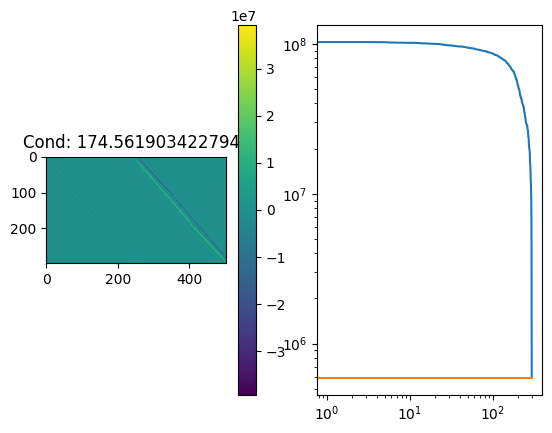

Everything has been loaded and the calibration are done!


In [3]:
param = initializeParameterFile()
KAO = initialize_AO_hardware(param)

M1_opd = KAO.opd_M1.OPD
ncpa = KAO.opd_ncpa.OPD
jitter_x = KAO.jitter.x

Re-initializing WFS...
Acquiring reference slopes..
updating the flux of the SHWFS object
Done!
Setting slopes units..
Done!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SHACK HARTMANN WFS %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    Subapertures            20        
  Subaperture Size         0.55              [m]        
     Pixel FoV             0.85            [arcsec]     
   Subapertue FoV          3.38            [arcsec]     
 Valid Subaperture         252        
   Binning Factor           1         
   Spot Sampling    0.2857142857142857    [pix/FWHM]    
   Geometric WFS          False       
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Flux updated, magnitude is  5 and flux is 1.09e+08
Flux updated, magnitude is  5 and flux is 1.90e+07
Telescope and Atmosphere combined!
updating the flux of the SHWFS object


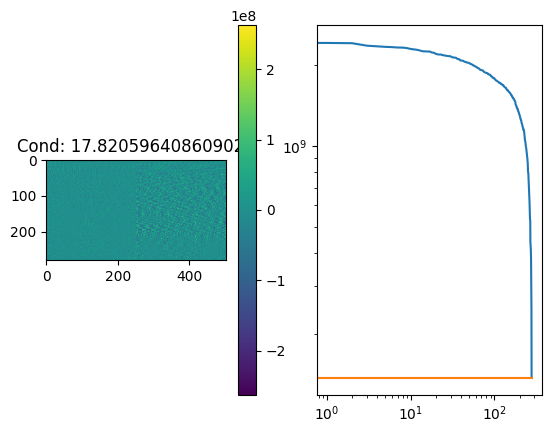

/var/folders/g2/4by_wvp50hq5wxb7sgwwwmxm0000gn/T/ipykernel_92096/168881313.py:107: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  aperture = evaluate_supersampled(circular_aperture(D * 1.01), pupil_grid, 8) * np.reshape (zero_padded_OOPAO_pupil, int(nPx**2))
/var/folders/g2/4by_wvp50hq5wxb7sgwwwmxm0000gn/T/ipykernel_92096/168881313.py:113: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  pupil_outer = circular_aperture(pupil_diameter)(grid)
/var/folders/g2/4by_wvp50hq5wxb7sgwwwmxm0000gn/T/ipykernel_92096/168881313.py:114: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  pupil_inner = circular_aperture(central_obscuration_diameter)(grid)


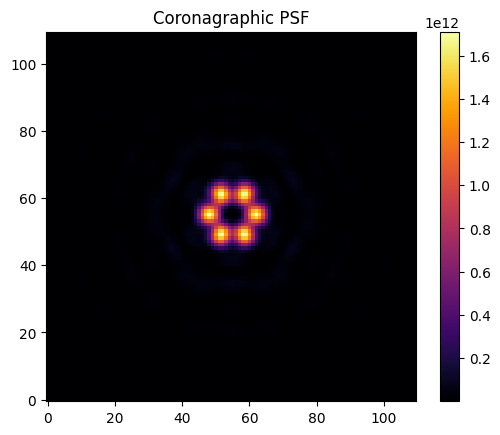

/var/folders/g2/4by_wvp50hq5wxb7sgwwwmxm0000gn/T/ipykernel_92096/168881313.py:167: RuntimeWarning: invalid value encountered in power
  plt.figure(), plt.imshow(PSF_diff[size_psf-50:size_psf+50,size_psf-50:size_psf+50]**0.2), plt.colorbar(), plt.title('Diffraction limited PSF'), plt.show()


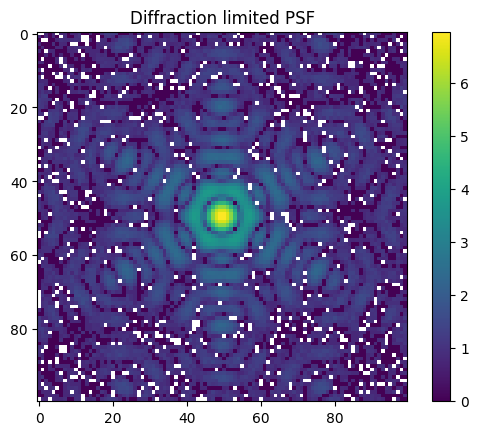

/var/folders/g2/4by_wvp50hq5wxb7sgwwwmxm0000gn/T/ipykernel_92096/168881313.py:168: RuntimeWarning: invalid value encountered in power
  plt.figure(), plt.imshow(PSF_ncpa[size_psf-50:size_psf+50,size_psf-50:size_psf+50]**0.2), plt.colorbar(), plt.title('NCPA PSF'), plt.show()


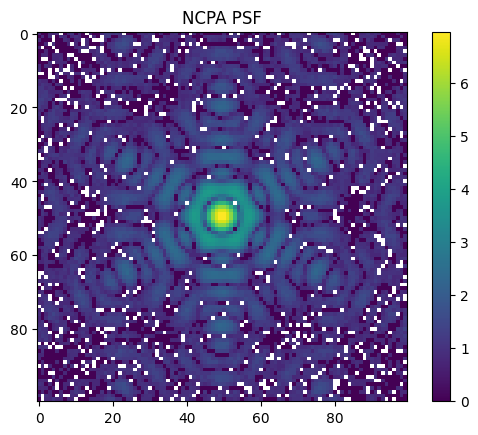

AO_sys has attributes: ['IF', 'M2C', 'M2C_TTM', 'PSF_diff', 'PSF_ncpa', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'atm', 'basis', 'calib_TTM', 'calib_modal', 'calib_zonal', 'detector_type', 'dm', 'filter_Piston', 'filter_TTM', 'jitter', 'keck_reconstructor', 'ksm', 'matching_inds', 'name_basis', 'ngs', 'opd_M1', 'opd_jitter', 'opd_ncpa', 'param', 'proj_seg', 'projector_dm', 'projector_modal', 'science', 'science_detector', 'seg1D', 'seg2D', 'tel', 'ttm', 'wfs', 'zwfs']
Loop0/100 Turbulence: 794.4318999812903 -- Residual:794.4318999812903 -- Fitting:133.9303800146364 -- SR:0.005260260900858824



/var/folders/g2/4by_wvp50hq5wxb7sgwwwmxm0000gn/T/ipykernel_92096/168881313.py:231: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  L_psf[i, :, :] = np.reshape(L_psf_temp, (int(np.sqrt(np.shape(L_psf_temp))), int(np.sqrt(np.shape(L_psf_temp)))))
/var/folders/g2/4by_wvp50hq5wxb7sgwwwmxm0000gn/T/ipykernel_92096/168881313.py:237: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  L_coro[i, :, :] = np.reshape(L_coro_temp, (int(np.sqrt(np.shape(L_coro_temp))), int(np.sqrt(np.shape(L_coro_temp)))))


AO_sys has attributes: ['IF', 'M2C', 'M2C_TTM', 'PSF_diff', 'PSF_ncpa', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'atm', 'basis', 'calib_TTM', 'calib_modal', 'calib_zonal', 'detector_type', 'dm', 'filter_Piston', 'filter_TTM', 'jitter', 'keck_reconstructor', 'ksm', 'matching_inds', 'name_basis', 'ngs', 'opd_M1', 'opd_jitter', 'opd_ncpa', 'param', 'proj_seg', 'projector_dm', 'projector_modal', 'science', 'science_detector', 'seg1D', 'seg2D', 'tel', 'ttm', 'wfs', 'zwfs']
Loop1/100 Turbulence: 793.9950714603965 -- Residual:793.9950714603965 -- Fitting:133.87517873905728 -- SR:0.00529069666368086

AO_sys has attributes: ['IF', 'M2C', 'M2C_TTM', 'PSF_diff', 'PSF_ncpa', '__class__', '__delattr__

In [4]:
KAO.param['print_display'] =True
KAO.param['nLoop']=100

AO_output_modal, PSF, PSF_c = close_loop(KAO)
SR_mode = AO_output_modal['SR']
res_mode = AO_output_modal['residual']
PSF_LE_mode = AO_output_modal['PSF_LE']

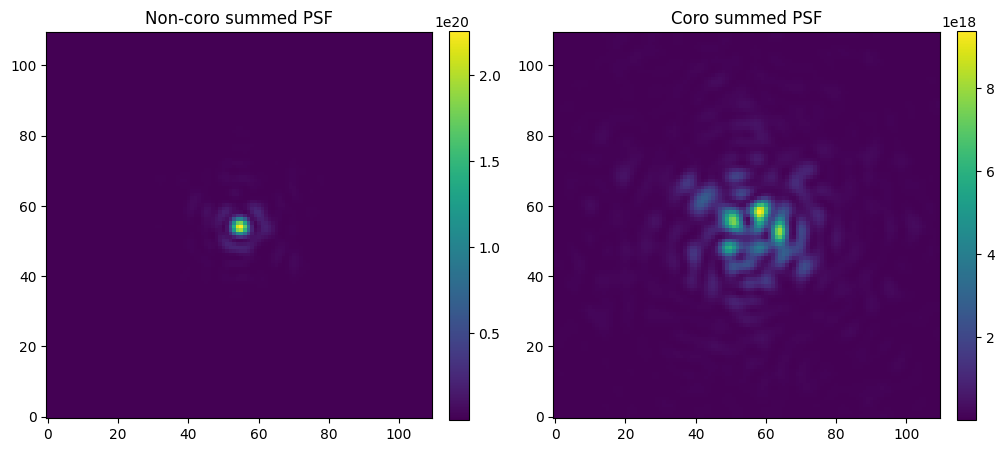

'\nf1 = "/Users/mayragutierrez/keckAOSim/keckSim/simulations_codes/MGDATA/L_current_coro_240nm_mag5_1759662621887816_20s_sum.fits"\nf2 = "/Users/mayragutierrez/keckAOSim/keckSim/simulations_codes/MGDATA/L_current_psf_240nm_mag5_1759662621887816_20s_sum.fits"\n\nd1 = fits.getdata(f1)\nd2 = fits.getdata(f2)\n\nfig, axs = plt.subplots(1, 2, figsize=(12,6))\n\nim2 = axs[0].imshow(d2, origin="lower", cmap="viridis")#, norm=plt.matplotlib.colors.LogNorm())\nfig.colorbar(im2, ax=axs[0], fraction=0.046, pad=0.04)\naxs[0].set_title("Non-Coronagraphic PSF")\n\nim1 = axs[1].imshow(d1, origin="lower", cmap="viridis")#, norm=plt.matplotlib.colors.LogNorm())\nfig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)\naxs[1].set_title("Coronagraphic PSF")\n\nplt.tight_layout()\nplt.show()\n'

In [5]:
psf_sum = np.sum(PSF, axis=0)
coro_sum = np.sum(PSF_c, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12,6))
im1=axes[0].imshow(psf_sum, origin="lower", cmap="viridis")
axes[0].set_title("Non-coro summed PSF")
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
im2 = axes[1].imshow(coro_sum, origin="lower", cmap="viridis")
axes[1].set_title("Coro summed PSF")
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
plt.show()
'''
f1 = "/Users/mayragutierrez/keckAOSim/keckSim/simulations_codes/MGDATA/L_current_coro_240nm_mag5_1759662621887816_20s_sum.fits"
f2 = "/Users/mayragutierrez/keckAOSim/keckSim/simulations_codes/MGDATA/L_current_psf_240nm_mag5_1759662621887816_20s_sum.fits"

d1 = fits.getdata(f1)
d2 = fits.getdata(f2)

fig, axs = plt.subplots(1, 2, figsize=(12,6))

im2 = axs[0].imshow(d2, origin="lower", cmap="viridis")#, norm=plt.matplotlib.colors.LogNorm())
fig.colorbar(im2, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].set_title("Non-Coronagraphic PSF")

im1 = axs[1].imshow(d1, origin="lower", cmap="viridis")#, norm=plt.matplotlib.colors.LogNorm())
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].set_title("Coronagraphic PSF")

plt.tight_layout()
plt.show()
'''

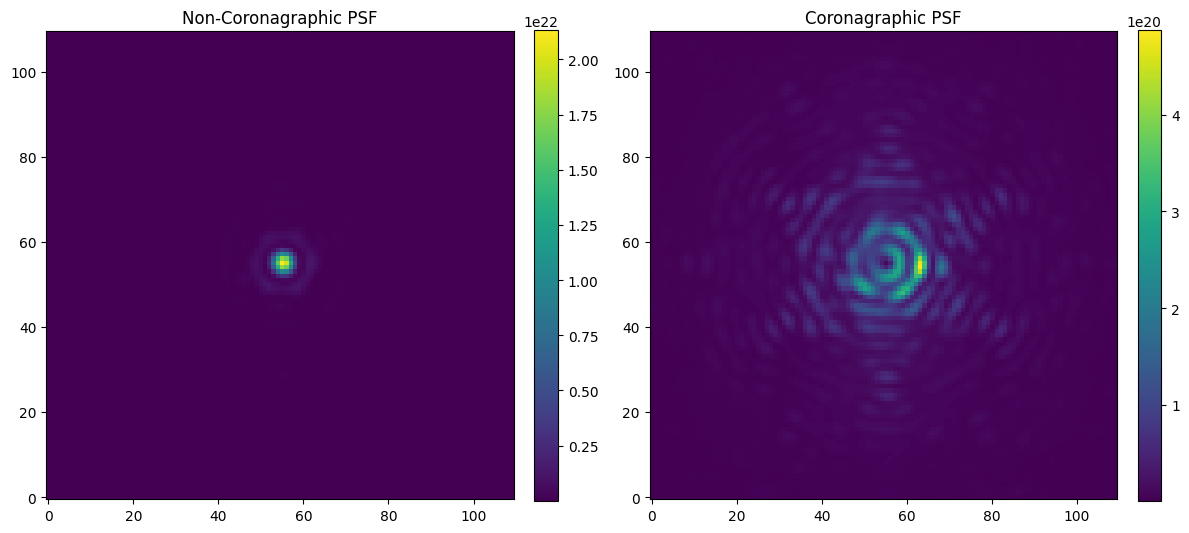

In [6]:
f1 = "/Users/mayragutierrez/keckAOSim/keckSim/simulations_codes/MGDATA/L_current_coro_120nm_mag5_1759719033925917_20s_sum.fits"
f2 = "/Users/mayragutierrez/keckAOSim/keckSim/simulations_codes/MGDATA/L_current_psf_120nm_mag5_1759719033925917_20s_sum.fits"

d1 = fits.getdata(f1)
d2 = fits.getdata(f2)

fig, axs = plt.subplots(1, 2, figsize=(12,6))

im2 = axs[0].imshow(d2, origin="lower", cmap="viridis")#, norm=plt.matplotlib.colors.LogNorm())
fig.colorbar(im2, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].set_title("Non-Coronagraphic PSF")

im1 = axs[1].imshow(d1, origin="lower", cmap="viridis")#, norm=plt.matplotlib.colors.LogNorm())
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].set_title("Coronagraphic PSF")



plt.tight_layout()
plt.show()